In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [24]:
from glob import glob
from tqdm import tqdm
from os.path import expanduser, join, basename, dirname
import xarray as xr
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from shutil import copy
from sklearn.model_selection import StratifiedKFold
import torch
from tempfile import TemporaryDirectory

from albk.data.utils import idx_to_locate
use_disjoint_files = False
from torch.utils.data import TensorDataset, DataLoader


import torch
import torch.nn as nn

from glob import glob
from os.path import expanduser, join, basename, dirname
import xarray as xr
import numpy as np
from tqdm import tqdm
import pandas as pd
from joblib import Parallel, delayed
from itertools import product
from astra.torch.models import EfficientNetClassifier,EfficientNet_B0_Weights   
from astra.torch.utils import train_fn

import torchvision.models as models
from astra.torch.metrics import accuracy_score, f1_score, precision_score, recall_score

In [25]:
# Load the saved tensors
loaded_data = torch.load("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/tensor_data/data.pt")

# Access the tensors
index = loaded_data['index']
images = loaded_data['images']
labels = loaded_data['labels']

In [26]:
images=images[:2000]
labels=labels[:2000]
images.shape, labels.shape


(torch.Size([2000, 3, 224, 224]), torch.Size([2000]))

In [6]:
from collections import Counter

fold_data = []  # List to store data from each fold

seed = 42  # Use your desired random seed
splitter = StratifiedKFold(n_splits=4, shuffle=True, random_state=seed)
images = images / 255
    # mean normalize
images = (images - images.mean(dim=(0, 2, 3), keepdim=True)) / images.std(dim=(0, 2, 3), keepdim=True)
for fold, (train_idx, test_idx) in enumerate(splitter.split(images, labels)):
    X_train, X_test = images[train_idx], images[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    # Count occurrences of each class in train and test sets
    train_counter = Counter(y_train.numpy())
    test_counter = Counter(y_test.numpy())
    print(train_counter)
    print(test_counter)
    print(f"Fold {fold + 1} - Train: {train_counter}, Test: {test_counter}")

    fold_data.append({
        'fold': fold + 1,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'train_counter': train_counter,
        'test_counter': test_counter
    })

Counter({0: 1369, 1: 131})
Counter({0: 457, 1: 43})
Fold 1 - Train: Counter({0: 1369, 1: 131}), Test: Counter({0: 457, 1: 43})
Counter({0: 1369, 1: 131})
Counter({0: 457, 1: 43})
Fold 2 - Train: Counter({0: 1369, 1: 131}), Test: Counter({0: 457, 1: 43})
Counter({0: 1370, 1: 130})
Counter({0: 456, 1: 44})
Fold 3 - Train: Counter({0: 1370, 1: 130}), Test: Counter({0: 456, 1: 44})
Counter({0: 1370, 1: 130})
Counter({0: 456, 1: 44})
Fold 4 - Train: Counter({0: 1370, 1: 130}), Test: Counter({0: 456, 1: 44})


In [7]:
train_dataset=TensorDataset(X_train, y_train)
test_dataset=TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size=512
# Lists to store metrics for each fold
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for fold_info in fold_data:
    fold = fold_info['fold']
    print("Fold: ", fold)
    X_train = fold_info['X_train']
    y_train = fold_info['y_train']
    X_test = fold_info['X_test']
    y_test = fold_info['y_test']
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    # Create DataLoader for training and testing
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    # Create and train the model
    #print datatype of trainloader
    print("trainloader datatype: ", train_loader.dataset.tensors[1].dtype)
    print("testloader datatype: ", test_loader.dataset.tensors[0].dtype)
    train_model = EfficientNetClassifier    (
        models.efficientnet_b0, EfficientNet_B0_Weights, n_classes=2, activation=nn.ReLU(), dropout=0.1
    ).to(device)

    iter_losses, epoch_losses = train_fn(
        train_model,
        nn.CrossEntropyLoss(),
        dataloader=train_loader,
        lr=3e-4,
        epochs=100,
        verbose=True,
        wandb_log=False,
    )

    # Evaluate the model on the test set
    with torch.no_grad():
        pred_classes = train_model.predict_class(
            dataloader=test_loader, batch_size=batch_size, verbose=True
        ).to(device)

    test_labels = y_test.to(device)
    # Calculate and print metrics for each fold
    
    accuracy = accuracy_score(pred_classes,test_labels)
    precision = precision_score( pred_classes,test_labels)
    recall = recall_score( pred_classes,test_labels)
    f1 = f1_score( pred_classes,test_labels)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\n")
    # Calculate and store metrics for each fold
    accuracy_list.append(accuracy_score( pred_classes,test_labels))
    precision_list.append(precision_score( pred_classes,test_labels))
    recall_list.append(recall_score( pred_classes,test_labels))
    f1_list.append(f1_score( pred_classes,test_labels))

# Calculate and print the mean of metrics across all folds
print("Mean Accuracy: ", sum(accuracy_list) / len(accuracy_list))
print("Mean Precision: ", sum(precision_list) / len(precision_list))
print("Mean Recall: ", sum(recall_list) / len(recall_list))
print("Mean F1: ", sum(f1_list) / len(f1_list))

Fold:  1
trainloader datatype:  torch.uint8
testloader datatype:  torch.float32


/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 1/1 [00:10<00:00, 10.29s/it]


Accuracy: 0.9600
Precision: 0.7674
Recall: 0.7674
F1 Score: 0.7674


Fold:  2
trainloader datatype:  torch.uint8
testloader datatype:  torch.float32


100%|██████████| 1/1 [00:00<00:00,  6.02it/s]


Accuracy: 0.9580
Precision: 0.7292
Recall: 0.8140
F1 Score: 0.7692


Fold:  3
trainloader datatype:  torch.uint8
testloader datatype:  torch.float32


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


Accuracy: 0.9560
Precision: 0.7750
Recall: 0.7045
F1 Score: 0.7381


Fold:  4
trainloader datatype:  torch.uint8
testloader datatype:  torch.float32


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

Accuracy: 0.9600
Precision: 0.9286
Recall: 0.5909
F1 Score: 0.7222


Mean Accuracy:  tensor(0.9585, device='cuda:0')
Mean Precision:  tensor(0.8000, device='cuda:0')
Mean Recall:  tensor(0.7192, device='cuda:0')
Mean F1:  tensor(0.7492, device='cuda:0')


In [54]:
# Load the saved tensors
loaded_data = torch.load("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/tensor_data/test_data.pt")

# Access the tensors
index1 = loaded_data['index']
images1 = loaded_data['images']
labels1= loaded_data['labels']

In [55]:
images1=images1[:2000]
labels1=labels1[:2000]
images1.shape, labels1.shape

(torch.Size([2000, 3, 224, 224]), torch.Size([2000]))

In [56]:
from collections import Counter

fold_data1 = []  # List to store data from each fold

seed = 42  # Use your desired random seed
splitter = StratifiedKFold(n_splits=4, shuffle=True, random_state=seed)
images1 = images1 / 255
    # mean normalize
images1 = (images1 - images1.mean(dim=(0, 2, 3), keepdim=True)) / images1.std(dim=(0, 2, 3), keepdim=True)
for fold, (train_idx, test_idx) in enumerate(splitter.split(images1, labels1)):
    X_train, X_test = images1[train_idx], images1[test_idx]
    y_train, y_test = labels1[train_idx], labels1[test_idx]

    # Count occurrences of each class in train and test sets
    train_counter = Counter(y_train.numpy())
    test_counter = Counter(y_test.numpy())
    print(train_counter)
    print(test_counter)
    print(f"Fold {fold + 1} - Train: {train_counter}, Test: {test_counter}")

    fold_data1.append({
        'fold': fold + 1,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'train_counter': train_counter,
        'test_counter': test_counter
    })

Counter({0: 1308, 1: 192})
Counter({0: 437, 1: 63})
Fold 1 - Train: Counter({0: 1308, 1: 192}), Test: Counter({0: 437, 1: 63})
Counter({0: 1309, 1: 191})
Counter({0: 436, 1: 64})
Fold 2 - Train: Counter({0: 1309, 1: 191}), Test: Counter({0: 436, 1: 64})
Counter({0: 1309, 1: 191})
Counter({0: 436, 1: 64})
Fold 3 - Train: Counter({0: 1309, 1: 191}), Test: Counter({0: 436, 1: 64})
Counter({0: 1309, 1: 191})
Counter({0: 436, 1: 64})
Fold 4 - Train: Counter({0: 1309, 1: 191}), Test: Counter({0: 436, 1: 64})


In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size=512
# Lists to store metrics for each fold
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for fold_info in fold_data1:
    fold = fold_info['fold']
    print("Fold: ", fold)
    X_train = fold_info['X_train']
    y_train = fold_info['y_train']
    X_test = fold_info['X_test']
    y_test = fold_info['y_test']
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    # Create DataLoader for training and testing
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    # Create and train the model
    #print datatype of trainloader
    print("trainloader datatype: ", train_loader.dataset.tensors[1].dtype)
    print("testloader datatype: ", test_loader.dataset.tensors[0].dtype)
    train_model = EfficientNetClassifier    (
        models.efficientnet_b0, EfficientNet_B0_Weights, n_classes=2, activation=nn.ReLU(), dropout=0.1
    ).to(device)

    iter_losses, epoch_losses = train_fn(
        train_model,
        nn.CrossEntropyLoss(),
        dataloader=train_loader,
        lr=3e-4,
        epochs=100,
        verbose=True,
        wandb_log=False,
    )

    # Evaluate the model on the test set
    with torch.no_grad():
        pred_classes = train_model.predict_class(
            dataloader=test_loader, batch_size=batch_size, verbose=True
        ).to(device)

    test_labels = y_test.to(device)
    # Calculate and print metrics for each fold
    
    accuracy = accuracy_score(pred_classes,test_labels)
    precision = precision_score( pred_classes,test_labels)
    recall = recall_score( pred_classes,test_labels)
    f1 = f1_score( pred_classes,test_labels)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\n")
    # Calculate and store metrics for each fold
    accuracy_list.append(accuracy_score( pred_classes,test_labels))
    precision_list.append(precision_score( pred_classes,test_labels))
    recall_list.append(recall_score( pred_classes,test_labels))
    f1_list.append(f1_score( pred_classes,test_labels))

# Calculate and print the mean of metrics across all folds
print("Mean Accuracy: ", sum(accuracy_list) / len(accuracy_list))
print("Mean Precision: ", sum(precision_list) / len(precision_list))
print("Mean Recall: ", sum(recall_list) / len(recall_list))
print("Mean F1: ", sum(f1_list) / len(f1_list))

Fold:  1
trainloader datatype:  torch.uint8
testloader datatype:  torch.float32


/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


Accuracy: 0.9540
Precision: 0.8571
Recall: 0.7619
F1 Score: 0.8067


Fold:  2
trainloader datatype:  torch.uint8
testloader datatype:  torch.float32


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


Accuracy: 0.9540
Precision: 0.8254
Recall: 0.8125
F1 Score: 0.8189


Fold:  3
trainloader datatype:  torch.uint8
testloader datatype:  torch.float32


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


Accuracy: 0.9460
Precision: 0.8246
Recall: 0.7344
F1 Score: 0.7769


Fold:  4
trainloader datatype:  torch.uint8
testloader datatype:  torch.float32


100%|██████████| 1/1 [00:00<00:00,  6.46it/s]


Accuracy: 0.9380
Precision: 0.8113
Recall: 0.6719
F1 Score: 0.7350


Mean Accuracy:  tensor(0.9480, device='cuda:0')
Mean Precision:  tensor(0.8296, device='cuda:0')
Mean Recall:  tensor(0.7452, device='cuda:0')
Mean F1:  tensor(0.7844, device='cuda:0')


: 

In [42]:
print(images.shape, labels.shape)
print(images1.shape, labels1.shape)  
images = images / 255
    # mean normalize
images = (images - images.mean(dim=(0, 2, 3), keepdim=True)) / images.std(dim=(0, 2, 3), keepdim=True)
images1 = images1 / 255
    # mean normalize
images1 = (images1 - images1.mean(dim=(0, 2, 3), keepdim=True)) / images1.std(dim=(0, 2, 3), keepdim=True)
train_dataset = TensorDataset(images, labels)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=8)
test_dataset = TensorDataset(images1, labels1)
test_loaderr = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=8)


torch.Size([2000, 3, 224, 224]) torch.Size([2000])
torch.Size([2000, 3, 224, 224]) torch.Size([2000])


In [43]:
train_model = EfficientNetClassifier(
    models.efficientnet_b0,EfficientNet_B0_Weights, n_classes=2, activation=nn.ReLU(), dropout=0.1
).to(device)

iter_losses, epoch_losses = train_fn(
    train_model,
    nn.CrossEntropyLoss(),
    dataloader=train_loader,
    lr=3e-4,
    epochs=100,
    verbose=True,
    wandb_log=False,
)

/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Loss: 0.00442287: 100%|██████████| 100/100 [11:10<00:00,  6.71s/it]


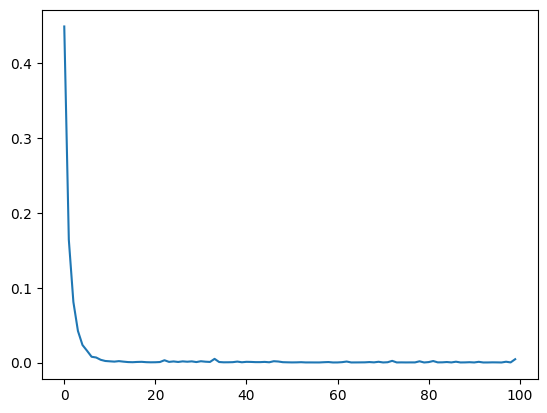

In [45]:
import matplotlib.pyplot as plt 
plt.plot(epoch_losses)

In [53]:
print(len(labels1))
print(len(images1))
test_dataset = TensorDataset(images1, labels1)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=8)
with torch.no_grad():
    pred_classes =train_model.predict_class(
        dataloader=test_loader, batch_size=254, verbose=True
    ).to(device)
print(len(pred_classes))
test_labels = labels1.to(device)
print("Accuracy: ", accuracy_score(pred_classes,test_labels))
print("Precision: ", precision_score(pred_classes,test_labels))
print("Recall: ", recall_score(pred_classes,test_labels))
print("F1: ", f1_score(pred_classes,test_labels))

2000
2000


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]

2000
Accuracy:  tensor(0.8715, device='cuda:0')
Precision:  tensor(0.4953, device='cuda:0')
Recall:  tensor(0.4118, device='cuda:0')
F1:  tensor(0.4497, device='cuda:0')
